# Desertification Index from MODIS Satellite Data

In [ ]:
# ClimateSERV API user and password
%run "dataLogin.ipynb"

import pandas as pd
import matplotlib.pyplot as plt
import climateservaccess as ca
import json
import ipywidgets as widgets
import pyperclip
import geopandas as gpd
from shapely.geometry import Polygon
import folium
import datetime
import numpy as np
import os
import requests
import time
import rasterio
import rasterio.plot
from sklearn.linear_model import LinearRegression

## Definitions

In [ ]:
# Variables for APPEEARS API
api = 'https://appeears.earthdatacloud.nasa.gov/api/'  
_res = 15 # area of interest size in decimal degrees (climateserv)
user = _usuario # APPEARS username
password = _senha # APPEARS password
_posMaps = [-8.708053542826518, -41.29821986351566] # center of area of interest
_ano_inicial = 2001  # start year
_ano_final = 2023   # end year
inDir = 'cache_data'  # cache directory name

# Create directories 
if not os.path.exists(inDir):
    os.makedirs(inDir)
_localdataName = f"{inDir}/{_posMaps[0]} {_posMaps[1]} {_res}"
if not os.path.exists(_localdataName):
    os.makedirs(_localdataName)
_graficos = _localdataName + "/resultados/"
if not os.path.exists(_graficos):
    os.makedirs(_graficos)

In [ ]:
def get_location_name(latitude, longitude):
  """Get geographical location name by latitude and longitude"""
  # construir a url da API do Nominatim
  url = f"https://nominatim.openstreetmap.org/reverse?format=json&lat={latitude}&lon={longitude}"
  # fazer uma requisição GET e obter a resposta em formato JSON
  response = requests.get(url).json()
  # extrair o nome do local do campo display_name
  location_name = response["address"]
  # retornar o nome do local
  return f"{location_name['city_district']} - {location_name['town']} - {location_name['state']} - {location_name['region']} - {location_name['country']}"
_NomeLocal = get_location_name(_posMaps[0],_posMaps[1])
print(f"Nome da região: {_NomeLocal}")

Nome da região: Poção de Afrânio - Afrânio - Pernambuco - Região Nordeste - Brasil


## Criando o bloco a ser analizado

As informações de coordenadas podem ser melhor visualizadas no seguinte site:

https://geojson.io/

Nele foi feito a seguinte demarcação do mapa para ser utilizado:

In [ ]:
link = "https://geojson.io/#map=8/"+str(round(_posMaps[0],3))+"/"+str(round(_posMaps[1],3))
print(link)

https://geojson.io/#map=8/-8.708/-41.298


Criar o GEOJson com essas coordenadas

In [ ]:
_quadrado = ca.getBox(_posMaps[0], _posMaps[1], _res) 
data_Json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            _quadrado[0],
            _quadrado[1],
            _quadrado[2],
            _quadrado[3],
            _quadrado[0]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
json_string = json.dumps(data_Json, indent=2)
print(json_string)
button = widgets.Button(description="Copiar GeJson")
def on_button_clicked(b):
    pyperclip.copy(json_string)
button.on_click(on_button_clicked)
button

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -48.79821986351566,
              -1.2080535428265176
            ],
            [
              -33.79821986351566,
              -1.2080535428265176
            ],
            [
              -33.79821986351566,
              -16.20805354282652
            ],
            [
              -48.79821986351566,
              -16.20805354282652
            ],
            [
              -48.79821986351566,
              -1.2080535428265176
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}


Button(description='Copiar GeJson', style=ButtonStyle())

In [ ]:
quadrado = Polygon(_quadrado)
quadrado_gdf = gpd.GeoSeries(quadrado)
geo_json_data = quadrado_gdf.to_json()
mapa = folium.Map(location=[_posMaps[0],_posMaps[1]])
#quadrado_gdf.add_to(mapa)
folium.GeoJson(geo_json_data).add_to(mapa)
# obter os limites do polígono
bounds = folium.GeoJson(geo_json_data).get_bounds()
# ajustar o mapa para os limites
zoom = mapa.fit_bounds(bounds)
mapa.save(_graficos+"map.html")
mapa

# Coletar dados de precipitação de todos os anos indo de mes a mes

In [ ]:
def dias_mes(mes, ano):
  data = datetime.date(ano, mes, 1)
  proximo_mes = data.replace(month=data.month % 12 + 1)
  ultimo_dia = proximo_mes - datetime.timedelta(days=1)
  return ultimo_dia.day
def precipitacao_mes(mes, ano):
    ultimodia = dias_mes(mes, ano)
    data_type = 26 #dados de precipitação
    start_date = "{:02d}/01/{}".format(mes, ano) 
    end_date = "{:02d}/{:02d}/{}".format(mes,ultimodia, ano+1)
    operation_type = 'average'
    polygon = _quadrado
    df = ca.getDataFrame(data_type, start_date, end_date, operation_type, polygon)
    data_df = pd.DataFrame(df['data'].to_list())
    valores = data_df["raw_value"].mean()
    return valores
def precipitacao_ano(ano):
    #_localdataName
    arqName = f"{_localdataName}/{ano} precipit data.csv"
    data_type = 26 #dados de precipitação
    start_date = "01/01/{}".format(ano) 
    end_date = "12/31/{}".format(ano)
    operation_type = 'average'
    polygon = _quadrado
    if os.path.exists(arqName):
        print(f"Arquivo do ano de {ano} já baixado, carregando arquivos locais ...")
        df = pd.read_csv(arqName+".raw")
        return df['raw_value']
    else:
        df = ca.getDataFrame(data_type, start_date, end_date, operation_type, polygon)
        df.to_csv(arqName)
        data_df = pd.DataFrame(df['data'].to_list())
        data_df['raw_value'].to_csv(arqName+".raw")
        return data_df['raw_value']
def downloadinfo(file_url, name):
    response = requests.get(file_url, stream=True)
    file_size = int(response.headers.get("content-length", 0))
    progress = tqdm.tqdm(total=file_size, unit="B", unit_scale=True)
    with open(name, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
            progress.update(len(chunk))
    progress.close()
_precipitacao = {}
for i in range(_ano_inicial,_ano_final+1):
    _precipitacao[i] = precipitacao_ano(i)

Arquivo do ano de 2001 já baixado, carregando arquivos locais ...
Arquivo do ano de 2002 já baixado, carregando arquivos locais ...
Arquivo do ano de 2003 já baixado, carregando arquivos locais ...
Arquivo do ano de 2004 já baixado, carregando arquivos locais ...
Arquivo do ano de 2005 já baixado, carregando arquivos locais ...
Arquivo do ano de 2006 já baixado, carregando arquivos locais ...
Arquivo do ano de 2007 já baixado, carregando arquivos locais ...
Arquivo do ano de 2008 já baixado, carregando arquivos locais ...
Arquivo do ano de 2009 já baixado, carregando arquivos locais ...
Arquivo do ano de 2010 já baixado, carregando arquivos locais ...
Arquivo do ano de 2011 já baixado, carregando arquivos locais ...
Arquivo do ano de 2012 já baixado, carregando arquivos locais ...
Arquivo do ano de 2013 já baixado, carregando arquivos locais ...
Arquivo do ano de 2014 já baixado, carregando arquivos locais ...
Arquivo do ano de 2015 já baixado, carregando arquivos locais ...
Arquivo do

In [ ]:
_dados = pd.DataFrame()
_dados["Ano"] = []
_dados["Precipitacao"] = []
for i in range(_ano_inicial,_ano_final+1):
    total = _precipitacao[i].sum()
    _dados.loc[len(_dados.index)] = [i, total]
_dados["Ano"] = _dados["Ano"].astype(int)
_dados

,Ano,Precipitacao
0,2001,1064.389200
1,2002,1177.970682
2,2003,1093.212461
3,2004,1284.734732
4,2005,1092.075341
5,2006,1094.814809
6,2007,1044.821001
7,2008,1223.196784
8,2009,1465.155767
9,2010,1097.754426


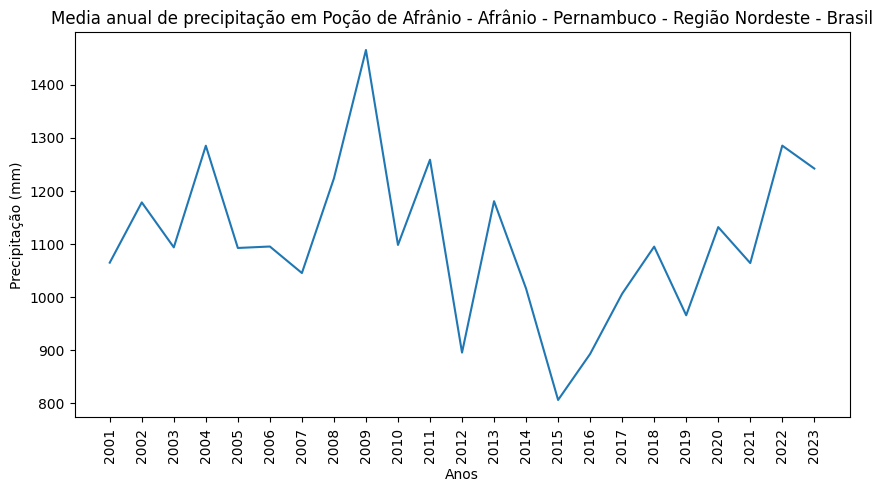

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(_dados["Ano"], _dados["Precipitacao"])
plt.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)], rotation=90)
plt.xlabel('Anos')
plt.ylabel('Precipitação (mm)')
plt.title(f'Media anual de precipitação em {_NomeLocal}')
plt.savefig(_graficos+"precipitacao.png", format="png")
plt.show()

# Pegar agora os dados de evapotranspiração

In [ ]:
token_response = requests.post('{}login'.format(api), auth=(user, password)).json()
token = token_response['token']                 
head = {'Authorization': 'Bearer {}'.format(token)}
print(token_response, token)

{'token_type': 'Bearer', 'token': 'MK7iEoJt66PQxtMVTGbUOB5kpi-VLcvaQS-zS9Fj9_op5dWDrTFuInpDR2MBD4Q2X7W7DNEo3Y8MVwNSdisdZA', 'expiration': '2024-01-26T11:08:55Z'} MK7iEoJt66PQxtMVTGbUOB5kpi-VLcvaQS-zS9Fj9_op5dWDrTFuInpDR2MBD4Q2X7W7DNEo3Y8MVwNSdisdZA


In [ ]:
produto_usado = "MOD16A3GF.061"
lst_response = requests.get('{}product/{}'.format(api, produto_usado)).json()
list(lst_response.keys())

['ET_500m', 'ET_QC_500m', 'LE_500m', 'PET_500m', 'PLE_500m']

In [ ]:
projections = requests.get('{}spatial/proj'.format(api)).json() 
projs = {}                                  # Create an empty dictionary
for p in projections: projs[p['Name']] = p
projs.keys() 

dict_keys(['native', 'geographic', 'sinu_modis', 'albers_weld_alaska', 'albers_weld_conus', 'albers_ard_alaska', 'albers_ard_conus', 'albers_ard_hawaii', 'easegrid_2_global', 'easegrid_2_north'])

In [ ]:
prodLayer = []
bandas_usadas = ['ET_500m',  'PET_500m']
for l in lst_response.keys():
    if l in bandas_usadas:
        prodLayer.append({
                "layer": l,
                "product": produto_usado
              })
prodLayer

[{'layer': 'ET_500m', 'product': 'MOD16A3GF.061'},
 {'layer': 'PET_500m', 'product': 'MOD16A3GF.061'}]

In [ ]:
#Configuraçoes de tarefa
task_type = ['point','area']        # Type of task, area or point
proj = projs['native']['Name']  # Set output projection 
outFormat = ['geotiff', 'netcdf4']  # Set output file format type
recurring = True                   # Specify True for a recurring date range
yearRange = [_ano_inicial, _ano_final]
task_name = _NomeLocal+" "+str(_ano_inicial)
task = {
        'task_type': task_type[1],
        'task_name': task_name,
        'params': {
             'dates': [
             {
                 'startDate': '01-01',
                 'endDate': '12-31',
                 'yearRange': yearRange,
                 'recurring': recurring
             }],
             'layers': prodLayer,
             'output': {
                     'format': {
                             'type': outFormat[0]}, 
                             'projection': proj},
             'geo': data_Json,
        }
    }
task

{'task_type': 'area',
 'task_name': 'Poção de Afrânio - Afrânio - Pernambuco - Região Nordeste - Brasil 2001',
 'params': {'dates': [{'startDate': '01-01',
    'endDate': '12-31',
    'yearRange': [2001, 2023],
    'recurring': True}],
  'layers': [{'layer': 'ET_500m', 'product': 'MOD16A3GF.061'},
   {'layer': 'PET_500m', 'product': 'MOD16A3GF.061'}],
  'output': {'format': {'type': 'geotiff'}, 'projection': 'native'},
  'geo': {'type': 'FeatureCollection',
   'features': [{'type': 'Feature',
     'properties': {},
     'geometry': {'coordinates': [[[-48.79821986351566, -1.2080535428265176],
        [-33.79821986351566, -1.2080535428265176],
        [-33.79821986351566, -16.20805354282652],
        [-48.79821986351566, -16.20805354282652],
        [-48.79821986351566, -1.2080535428265176]]],
      'type': 'Polygon'}}]}}}

In [ ]:
task_response = ""
_appEEARsDir = _localdataName+"/"+task_name
if not os.path.exists(_appEEARsDir):
    os.makedirs(_appEEARsDir)
    task_response = requests.post('{}task'.format(api), json=task, headers=head).json()
print(task_response)

In [ ]:
def status(id_tarefa):
    return requests.get('{}task/{}'.format(api, id_tarefa), headers=head).json()['status']
if task_response != "":
    task_id = task_response['task_id']                                               
    status_response = requests.get('{}status/{}'.format(api, task_id), headers=head).json() 
    print(status_response)
    starttime = time.time()
    intervalo = 20.0
    _status = status(task_id)
    while _status != 'done':
        _status = status(task_id)
        time.sleep(intervalo - ((time.time() - starttime) % intervalo))
        print(_status)
    print(_status)
else:
    print("Os dados já haviam sido baixados")

Os dados já haviam sido baixados


In [ ]:
if task_response != "":
    bundle = requests.get('{}bundle/{}'.format(api,task_id), headers=head).json()  # Call API and return bundle contents for the task_id as json
    files = {}                                                       # Create empty dictionary
    for f in bundle['files']: files[f['file_id']] = f['file_name']
    cont = 0
    numero = len(files)
    for f in files:
        if files[f].endswith('.tif'):
            filename = files[f].split('/')[1]
        else:
            filename = files[f] 
        if os.path.exists(_appEEARsDir +"/"+filename):
            cont += 1
        else:
            dl = requests.get('{}bundle/{}/{}'.format(api, task_id, f), headers=head, stream=True, allow_redirects = 'True')
            filepath = os.path.join(_appEEARsDir, filename)                                                      
            with open(filepath, 'wb') as f:                                                                
                for data in dl.iter_content(chunk_size=8192): f.write(data)
            cont += 1
        print(f"Baixando arquivos {cont} / {numero}")
    print('Todos os arquivos da tarefa salvos em: {}'.format(_appEEARsDir))

In [ ]:
if os.path.exists(_appEEARsDir +"/MOD16A3GF-061-Statistics.csv"):
    _dataEvapo = pd.read_csv(_appEEARsDir +"/MOD16A3GF-061-Statistics.csv")
_dataEvapo

,File Name,Dataset,aid,Date,Count,Minimum,Maximum,Range,Mean,Standard Deviation,Variance,Upper Quartile,Upper 1.5 IQR,Median,Lower 1.5 IQR,Lower Quartile
0,MOD16A3GF_061_ET_500m_doy2001001_aid0001,ET_500m,aid0001,2001-01-01,8943882,97.5,2841.9,"(97.5,2841.9)",864.467883,378.161334,143005.994644,1093.400,1867.7,780.0,97.5,577.2
1,MOD16A3GF_061_ET_500m_doy2002001_aid0001,ET_500m,aid0001,2002-01-01,8943882,142.6,2680.7,"(142.6,2680.7)",892.032089,362.642500,131509.583035,1114.900,1866.4,806.5,142.6,613.9
2,MOD16A3GF_061_ET_500m_doy2003001_aid0001,ET_500m,aid0001,2003-01-01,8943882,128.4,3006.7,"(128.4,3006.7)",902.295819,365.425971,133536.140322,1111.200,1827.0,833.8,128.4,634.0
3,MOD16A3GF_061_ET_500m_doy2004001_aid0001,ET_500m,aid0001,2004-01-01,8943882,183.0,3221.2,"(183.0,3221.2)",1002.019440,310.507557,96414.942875,1181.500,1786.4,948.9,183.0,778.2
4,MOD16A3GF_061_ET_500m_doy2005001_aid0001,ET_500m,aid0001,2005-01-01,8943882,150.9,2755.0,"(150.9,2755.0)",966.590774,302.865568,91727.552411,1136.000,1709.7,911.9,180.0,753.5
5,MOD16A3GF_061_ET_500m_doy2006001_aid0001,ET_500m,aid0001,2006-01-01,8943882,162.7,3213.6,"(162.7,3213.6)",1019.464120,311.299723,96907.517363,1212.300,1839.9,975.8,168.0,793.9
6,MOD16A3GF_061_ET_500m_doy2007001_aid0001,ET_500m,aid0001,2007-01-01,8943882,103.8,2635.0,"(103.8,2635.0)",859.061205,344.970173,119004.420266,1058.500,1733.8,770.7,103.8,608.3
7,MOD16A3GF_061_ET_500m_doy2008001_aid0001,ET_500m,aid0001,2008-01-01,8943882,183.0,3254.5,"(183.0,3254.5)",950.624989,309.013169,95489.138793,1138.800,1759.5,894.0,183.0,725.0
8,MOD16A3GF_061_ET_500m_doy2009001_aid0001,ET_500m,aid0001,2009-01-01,8943882,182.5,3313.8,"(182.5,3313.8)",1089.632511,290.047123,84127.333290,1273.200,1855.0,1060.9,303.5,885.3
9,MOD16A3GF_061_ET_500m_doy2010001_aid0001,ET_500m,aid0001,2010-01-01,8943882,123.2,3235.0,"(123.2,3235.0)",994.501310,334.491339,111884.455833,1181.000,1814.0,939.5,126.1,759.0


In [ ]:
mean_1, mean_2 = np.array_split(_dataEvapo["Mean"], 2)
nova_tabela1 = pd.DataFrame({"ET": mean_1})
nova_tabela2 = pd.DataFrame( {"PET": mean_2.to_list()})
_dados["ET"] = nova_tabela1["ET"]
_dados["PET"] = nova_tabela2["PET"]
#remover linhas invalidas
_dados.dropna(inplace=True)
_dados

/home/gladis/Ambientes/OndasGravitacionais/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


,Ano,Precipitacao,ET,PET
0,2001,1064.389200,864.467883,2457.733234
1,2002,1177.970682,892.032089,2478.380150
2,2003,1093.212461,902.295819,2436.395785
3,2004,1284.734732,1002.019440,2405.486364
4,2005,1092.075341,966.590774,2406.945936
5,2006,1094.814809,1019.464120,2375.198148
6,2007,1044.821001,859.061205,2473.555102
7,2008,1223.196784,950.624989,2359.098930
8,2009,1465.155767,1089.632511,2288.339963
9,2010,1097.754426,994.501310,2392.639434


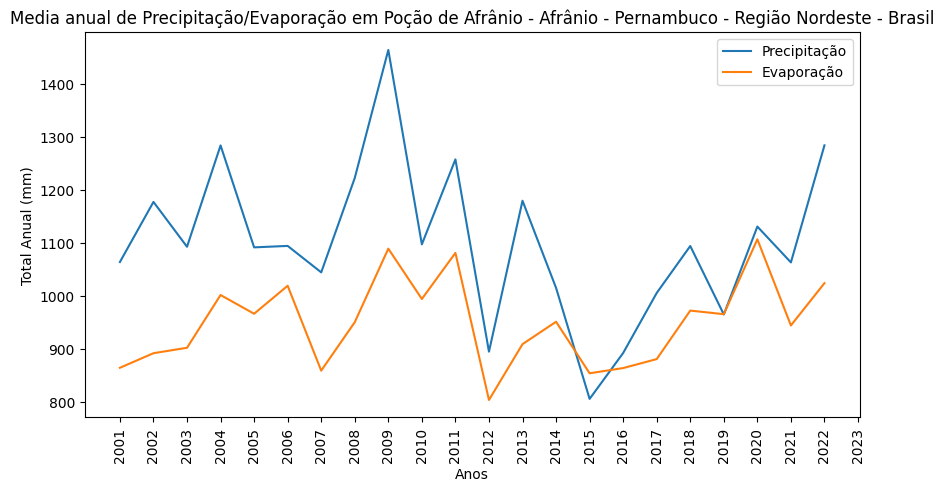

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(_dados["Ano"], _dados["Precipitacao"], label="Precipitação")
plt.plot(_dados["Ano"], _dados["ET"], label="Evaporação")
plt.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)],  rotation=90)
plt.xlabel('Anos')
plt.ylabel('Total Anual (mm)')
plt.title(f'Media anual de Precipitação/Evaporação em {_NomeLocal}')
plt.legend()
plt.savefig(_graficos+"precipitacao e evaporacao.png", format="png")
plt.show()

In [ ]:
_dados['Indice de Aridez UNEP'] = _dados["Precipitacao"] / _dados["PET"]
_dados['Aridez'] = _dados["Precipitacao"] / _dados["ET"]
_dados

,Ano,Precipitacao,ET,PET,Indice de Aridez UNEP,Aridez
0,2001,1064.389200,864.467883,2457.733234,0.433078,1.231265
1,2002,1177.970682,892.032089,2478.380150,0.475299,1.320547
2,2003,1093.212461,902.295819,2436.395785,0.448701,1.211590
3,2004,1284.734732,1002.019440,2405.486364,0.534085,1.282146
4,2005,1092.075341,966.590774,2406.945936,0.453718,1.129822
5,2006,1094.814809,1019.464120,2375.198148,0.460936,1.073912
6,2007,1044.821001,859.061205,2473.555102,0.422396,1.216236
7,2008,1223.196784,950.624989,2359.098930,0.518502,1.286729
8,2009,1465.155767,1089.632511,2288.339963,0.640270,1.344633
9,2010,1097.754426,994.501310,2392.639434,0.458805,1.103824


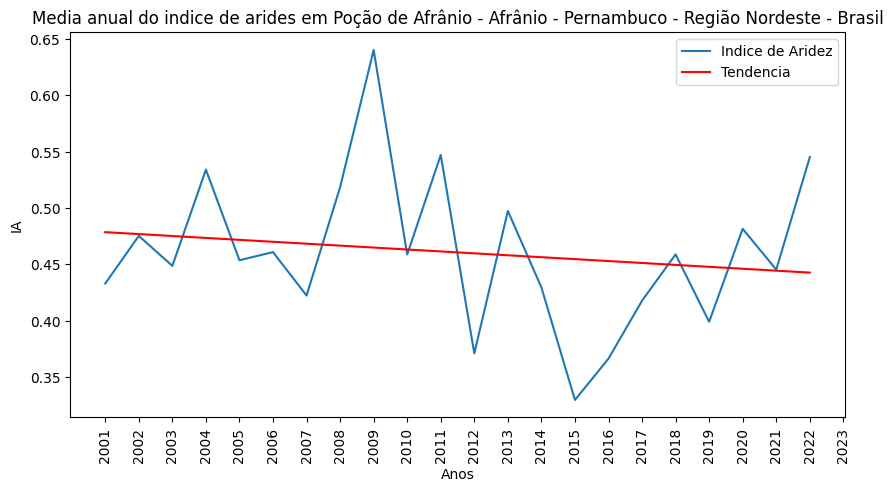

In [ ]:
z = np.polyfit(_dados["Ano"], _dados["Indice de Aridez UNEP"], 1)
p = np.poly1d(z) # Criando um objeto polinomial
plt.figure(figsize=(10,5))
plt.plot(_dados["Ano"], _dados["Indice de Aridez UNEP"],label="Indice de Aridez")
plt.plot(_dados["Ano"], p(_dados["Ano"]), 'r-',label="Tendencia")
plt.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)], rotation=90)
plt.xlabel('Anos')
plt.ylabel('IA')
plt.title(f'Media anual do indice de arides em {_NomeLocal}')
plt.legend()
plt.savefig(_graficos+"IA.png", format="png")
plt.show()

# calculando resultados

In [ ]:
def categoria_climatica(indice):
    if indice >= 0.65:
        return 'Úmida'
    elif indice >= 0.5:
        return 'Subúmida'
    elif indice >= 0.2:
        return 'Semiárida'
    elif indice >= 0.05:
        return 'Árida'
    else:
        return 'Hiperárida'
def risco_desertificacao(ai):
  if ai < 0.05:
    return "Acima de Muito Alto (MMA)"
  elif 0.05 <= ai <= 0.20:
    return "Muito Alto (MA)"
  elif 0.21 <= ai <= 0.50:
    return "Alto (A)"
  elif 0.51 <= ai <= 0.65:
    return "Moderado (M)"
  else:
    return "Baixo (B)"
_IndiceAridez = _dados['Indice de Aridez UNEP'].mean()
_Aridez = _dados['Indice de Aridez UNEP'].mean()
_AriderN = (p(_dados["Ano"])).mean()
aridez = _dados.iloc[-1]['Indice de Aridez UNEP']
print(f"Essa região está classificada atualmente como sendo uma região {aridez:.2f}, o que lhe classifica como uma região {categoria_climatica(aridez)}")
print(f"Entre os anos de {_ano_inicial } e {_ano_final}, a região teve um indice medio de {_AriderN:.2f}, o que lhe classifica como uma região {categoria_climatica(_AriderN)}")
print(f"A chance de desertificação da região está classificada como {risco_desertificacao(_AriderN)}")
#if a < 0:
#    print("Foi observado um processo de diminuição do total de chuva em relação ao total de evaporação")

Essa região está classificada atualmente como sendo uma região 0.55, o que lhe classifica como uma região Subúmida
Entre os anos de 2001 e 2023, a região teve um indice medio de 0.46, o que lhe classifica como uma região Semiárida
A chance de desertificação da região está classificada como Alto (A)


In [ ]:
_dados["Aridez2"] = _dados["ET"] / _dados["PET"]
_Aridez2 = _dados['Aridez2'].mean()
print(f"Comparando os 2 indices para verificar equivalencia {_Aridez:.2f} ~= {_Aridez2:.2f}")

Comparando os 2 indices para verificar equivalencia 0.46 ~= 0.40


In [ ]:
nomes = os.listdir(_appEEARsDir) 
_arquivos = [nome for nome in nomes if os.path.isfile(os.path.join(_appEEARsDir, nome))] 

In [ ]:
_bounds = 0
def mostraGraficoDoAno(ano):
    for f in _arquivos:
        nome = f#_arquivos[f]
        if "_ET_5" in nome and f"doy{ano}" in nome:
            et_tif = nome
        if "_PET_5" in nome and f"doy{ano}" in nome:
            pet_tif = nome
    et_tif = _appEEARsDir+"/"+et_tif
    pet_tif = _appEEARsDir+"/"+pet_tif
    with rasterio.open(et_tif) as et:
      et_data = et.read(1) 
    with rasterio.open(pet_tif) as pet:
      pet_data = pet.read(1) 
    arid_data = et_data / pet_data
    return arid_data
_mascara = 1
def PlotGrafico(data):
    plt.title(f'Região de:\n {_NomeLocal}')
    plt.imshow(data, cmap='jet_r', vmin=0, vmax=1)
    plt.colorbar(label='Aridez')
    mascara = np.where(data < 0.2, 0, np.nan)
    _mascara = mascara
    plt.imshow(mascara, cmap='gray', vmin=0, vmax=1, alpha=1)
    branco = np.where(data == 1, 0, np.nan)
    plt.imshow(branco, cmap='gray_r', vmin=0, vmax=1, alpha=1)
    plt.axis('off')
    plt.savefig(_graficos+"mapa IA.png", format="png")
    plt.show()
#PlotGrafico(mostraGraficoDoAno(_ano_final-1))

In [ ]:
_dado = []
for i in range(_ano_inicial,_ano_final,2):
    _dado.append(mostraGraficoDoAno(i))
_final = np.mean(_dado, axis=0)

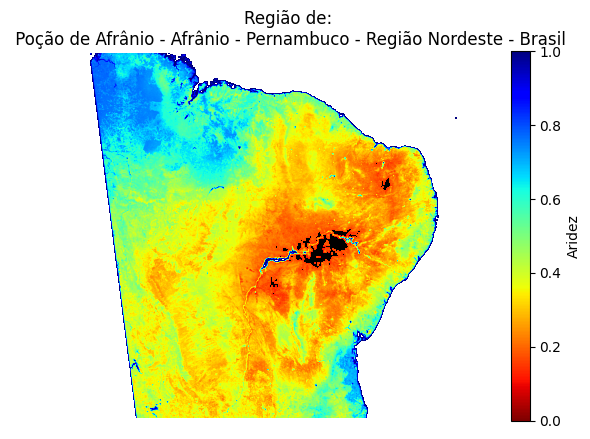

In [ ]:
PlotGrafico(_final)

# RAI

In [ ]:
def rai(precipitacao, media, desvio):
    return (precipitacao - media) / desvio * 100
# Calcula a media e o desvio da coluna Precipitacao
media = _dados['Precipitacao'].mean()
desvio = _dados['Precipitacao'].std()

# Cria uma nova coluna RAI aplicando a funcao rai a cada valor da coluna Precipitacao
_dados['RAI'] = _dados['Precipitacao'].apply(rai, args=(media, desvio))
_dados

,Ano,Precipitacao,ET,PET,Indice de Aridez UNEP,Aridez,Aridez2,RAI
0,2001,1064.389200,864.467883,2457.733234,0.433078,1.231265,0.351734,-24.816860
1,2002,1177.970682,892.032089,2478.380150,0.475299,1.320547,0.359925,51.340179
2,2003,1093.212461,902.295819,2436.395785,0.448701,1.211590,0.370340,-5.490697
3,2004,1284.734732,1002.019440,2405.486364,0.534085,1.282146,0.416556,122.926091
4,2005,1092.075341,966.590774,2406.945936,0.453718,1.129822,0.401584,-6.253143
5,2006,1094.814809,1019.464120,2375.198148,0.460936,1.073912,0.429212,-4.416314
6,2007,1044.821001,859.061205,2473.555102,0.422396,1.216236,0.347298,-37.937451
7,2008,1223.196784,950.624989,2359.098930,0.518502,1.286729,0.402961,81.664541
8,2009,1465.155767,1089.632511,2288.339963,0.640270,1.344633,0.476167,243.899436
9,2010,1097.754426,994.501310,2392.639434,0.458805,1.103824,0.415650,-2.445284


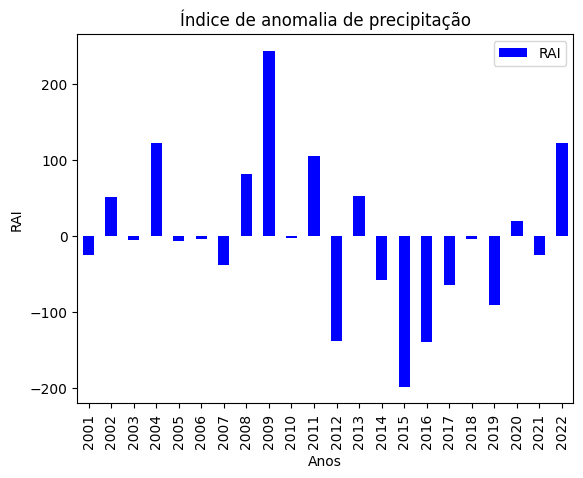

In [ ]:
_dados.plot(kind='bar', x='Ano', y='RAI', title='Índice de anomalia de precipitação', xlabel='Anos', ylabel='RAI', color='blue')
plt.savefig(_graficos+"RAI.png", format="png")
plt.show()

## Usando os dados para tentar prever o futuro caso nada seja feito

In [ ]:
df = _dados.copy()
# Separando as colunas em variáveis independentes (x) e dependentes (y)
x = df.iloc[:, 0].values.reshape(-1, 1) # Ano
y1 = df.iloc[:, 1].values.reshape(-1, 1) # Precipitacao
#y2 = df.iloc[:, 2].values.reshape(-1, 1) # ET
#y3 = df.iloc[:, 3].values.reshape(-1, 1) # PET
y4 = df.iloc[:, 4].values.reshape(-1, 1) # Indice de Aridez UNEP

# Criando e treinando os modelos de regressão linear para cada variável dependente
model1 = LinearRegression() # Modelo para Precipitacao
model1.fit(x, y1)

#model2 = LinearRegression() # Modelo para ET
#model2.fit(x, y2)

#model3 = LinearRegression() # Modelo para PET
#model3.fit(x, y3)

model4 = LinearRegression() # Modelo para Indice de Aridez UNEP
model4.fit(x, y4)

LinearRegression()

In [ ]:
# Criando um array com os valores de x para a previsão
x_pred = np.array([2023, 2024, 2025, 2030, 2040, 2050]).reshape(-1, 1)

# Prevendo os valores de y para os próximos anos
y1_pred = model1.predict(x_pred) # Previsão para Precipitacao
#y2_pred = model2.predict(x_pred) # Previsão para ET
#y3_pred = model3.predict(x_pred) # Previsão para PET
y4_pred = model4.predict(x_pred) # Previsão para Indice de Aridez UNEP

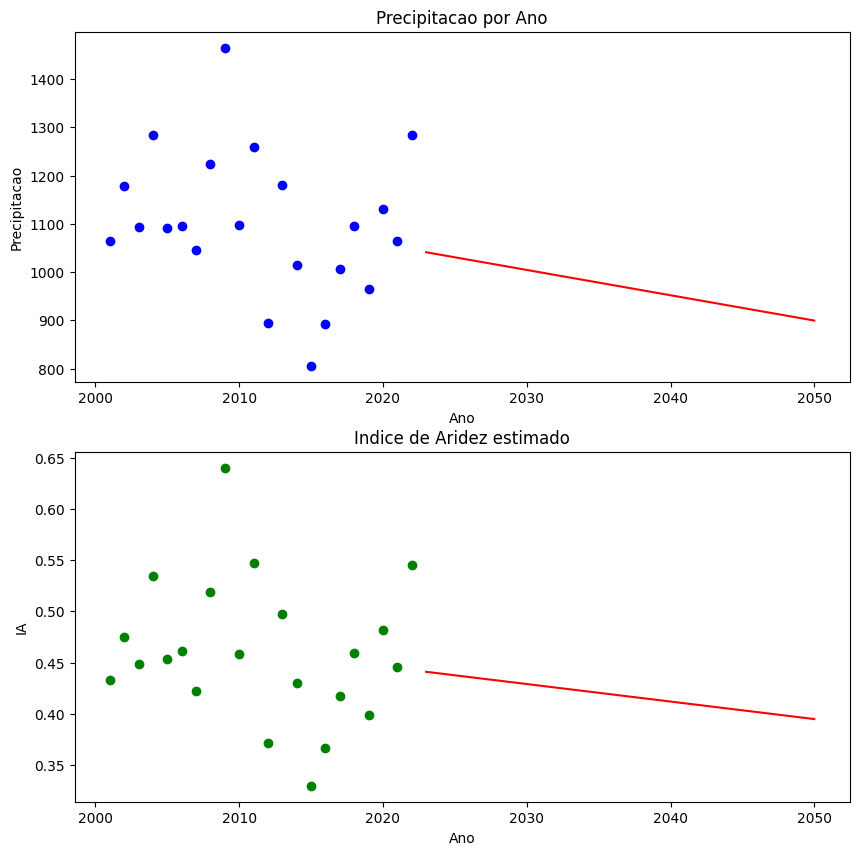

In [ ]:
# Visualizando os resultados em gráficos de linha
plt.figure(figsize=(10, 10)) # Ajustando o tamanho da figura

plt.subplot(2, 1, 1) # Criando o primeiro subplot
plt.plot(x, y1, 'bo') # Plotando os dados originais de Precipitacao
plt.plot(x_pred, y1_pred, 'r-') # Plotando a previsão de Precipitacao
plt.title('Precipitacao por Ano') # Adicionando o título
plt.xlabel('Ano') # Adicionando o rótulo do eixo x
plt.ylabel('Precipitacao') # Adicionando o rótulo do eixo y

plt.subplot(2, 1, 2) # Criando o segundo subplot
plt.plot(x, y4, 'go') # Plotando os dados originais
plt.plot(x_pred, y4_pred, 'r-') # Plotando a previsão 
plt.title('Indice de Aridez estimado') # Adicionando o título
plt.xlabel('Ano') # Adicionando o rótulo do eixo x
plt.ylabel('IA') # Adicionando o rótulo do eixo y
plt.savefig(_graficos+"Previsao.png", format="png")


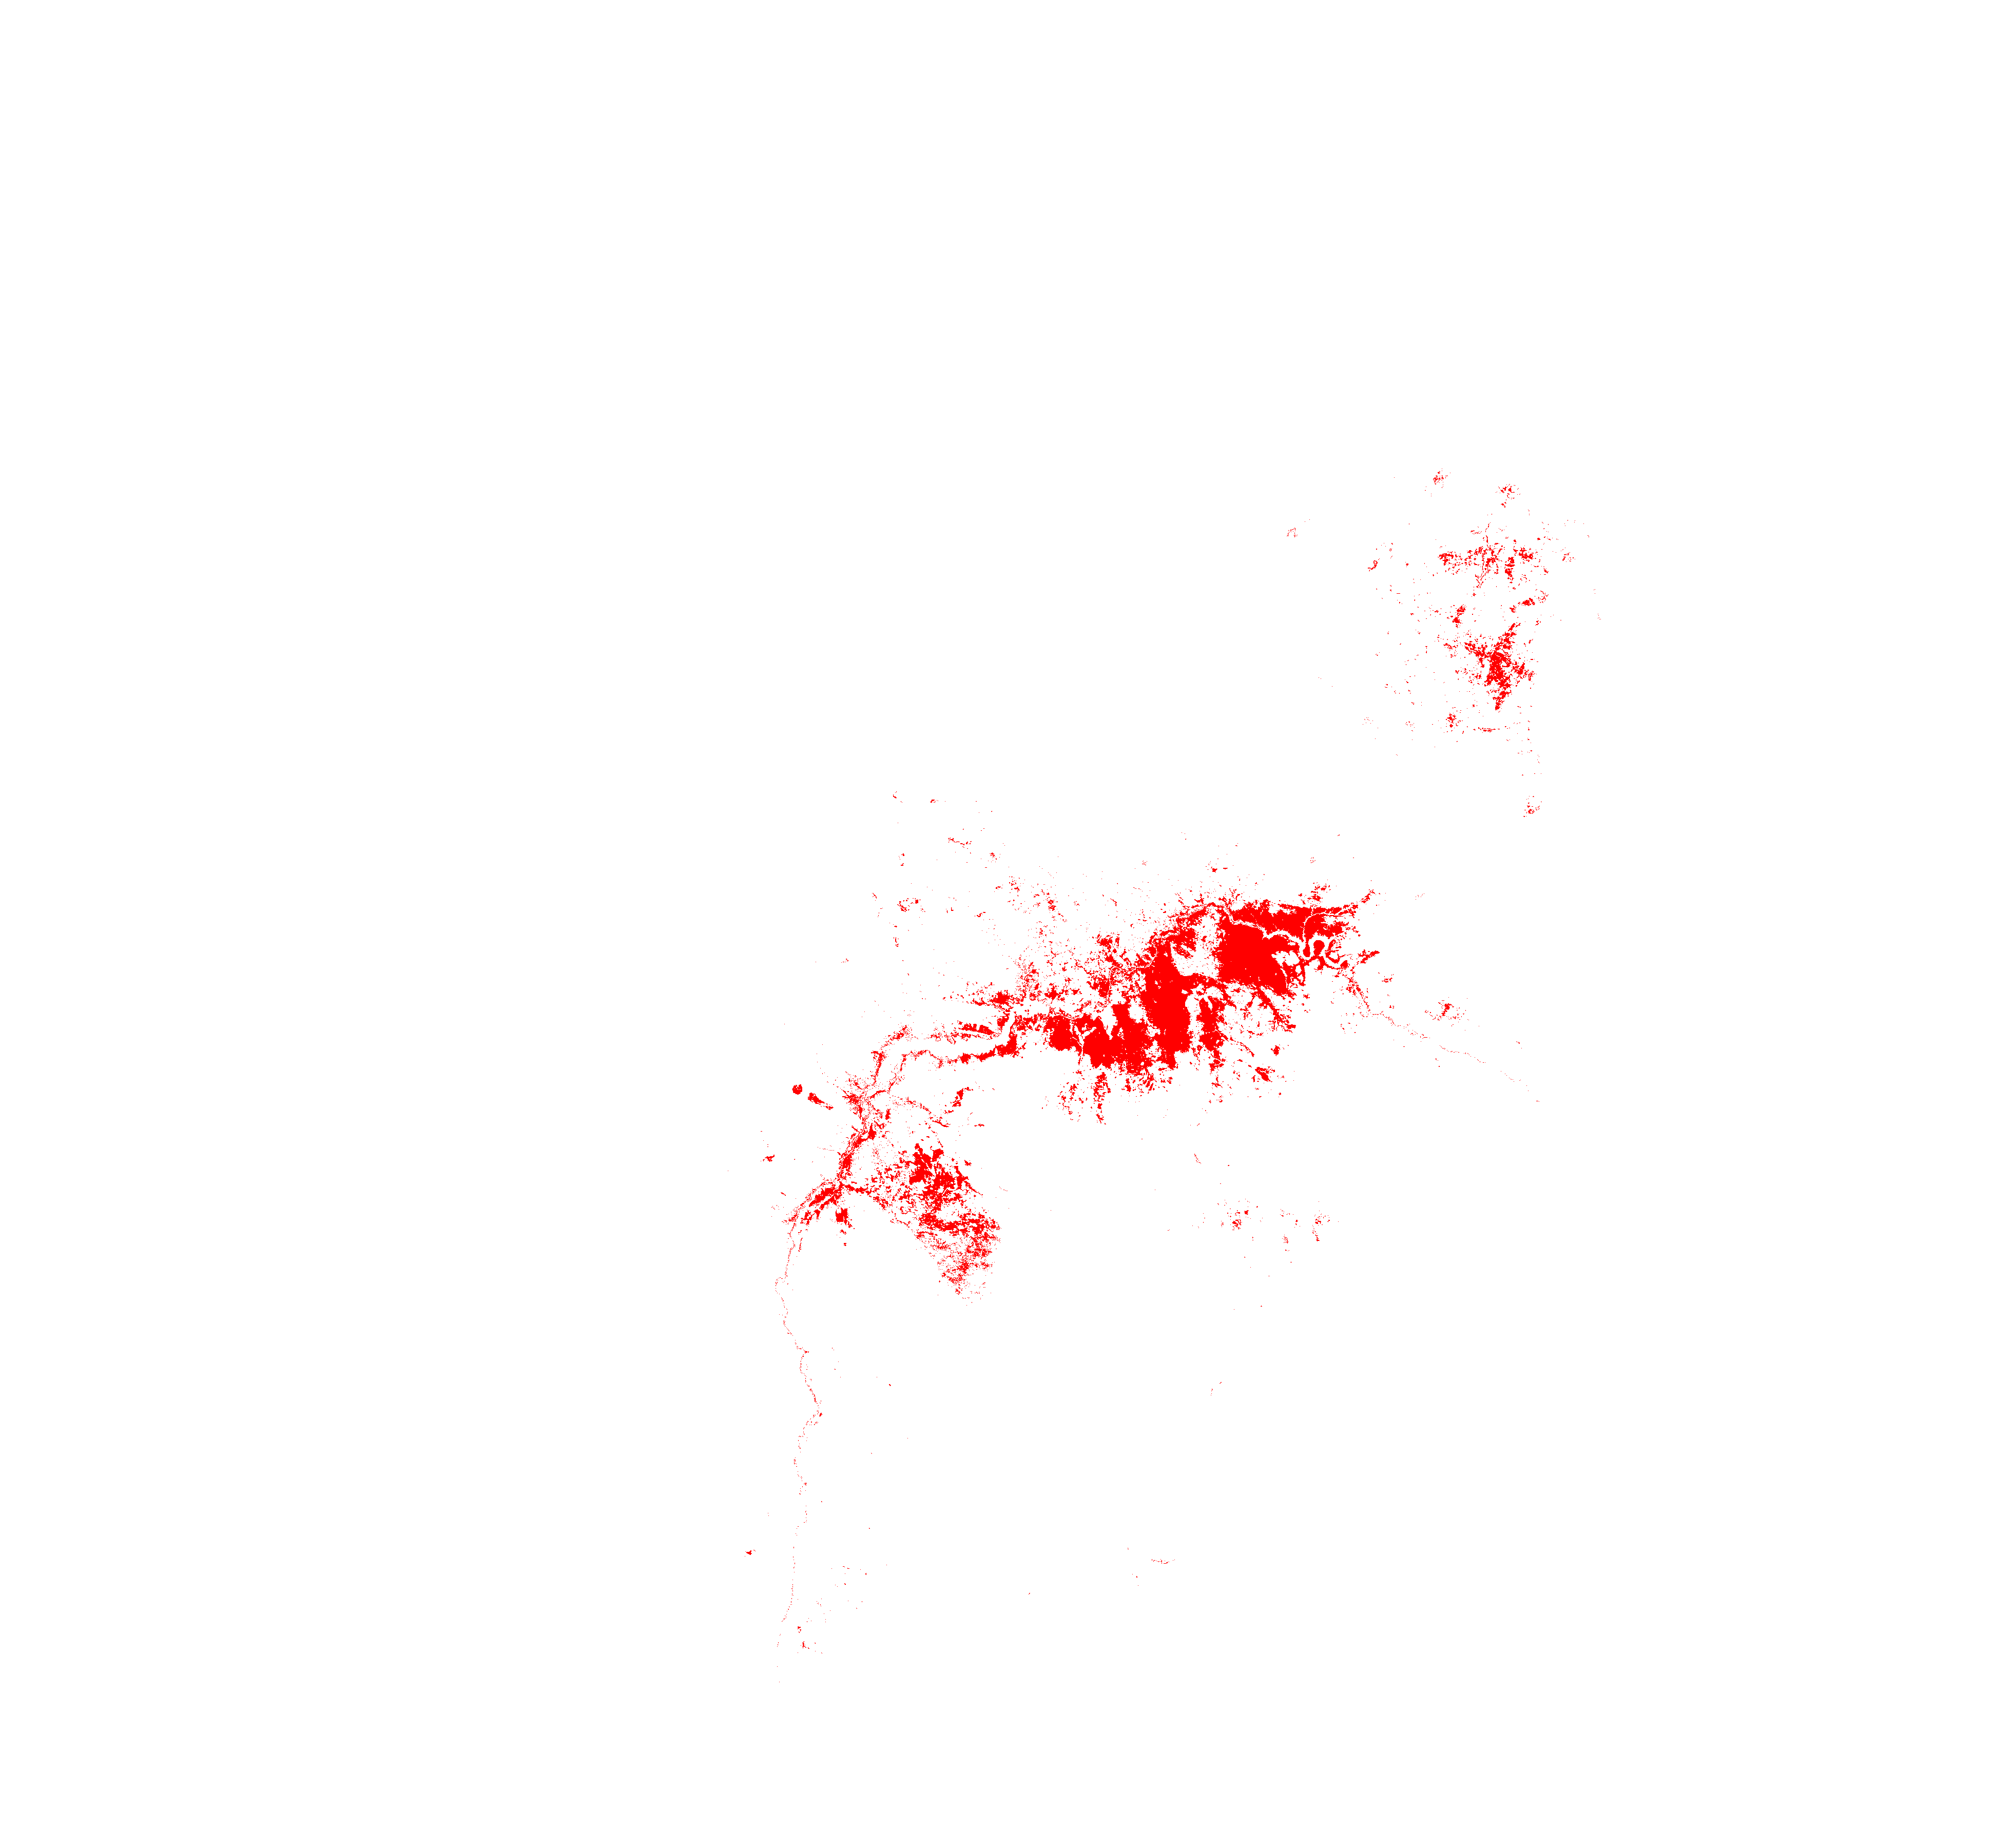

In [ ]:
def encontrar_limites(array):
  left = min(array[i][0] for i in range(len(array)))
  right = max(array[i][0] for i in range(len(array)))
  bottom = min(array[i][1] for i in range(len(array)))
  top = max(array[i][1] for i in range(len(array)))
  return left, right, bottom, top

# Ler a imagem tiff
#img = rasterio.open(_appEEARsDir+"/MOD16A3GF.061_ET_500m_doy2001001_aid0001.tif")
imagem = np.where(_final < 0.15, 0, 1)
imagem = 1- imagem
# Obter os limites geográficos da imagem
#bounds = polygon
left, right, bottom, top = encontrar_limites(_quadrado)
#print(left, right, bottom, top)

# Criar um objeto mapa
m = folium.Map(location=[(top+bottom)/2, (left+right)/2], zoom_start=5)

# Criar um objeto imagem
image = folium.raster_layers.ImageOverlay(
    name="Evapotranspiração",
    image=imagem,#img.read(1),
    bounds=[[bottom, left-1], [top, right+1]],
    colormap=lambda x: (1, 0, 0, x),
    opacity=1,
    interactive=True,
    zindex=1
)

# Adicionar o objeto imagem ao objeto mapa
image.add_to(m)

# Visualizar o mapa
m.save(_graficos+"map final.html")
m